Este notebook es para testear las metricas a calcular en las redes. Las mismas luego se pasarán a una clase *analizer*. 
Cosas a hacer:
* Comunidades
* Agregar attributos
* Modularidad: por partido y comunidad
* NMI
* Diversity: communities, parties
* Distancia
* Shortest path mean (de toda red)
* Shortest path entre partidos

In [1]:
year = 2018

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
from procesador_votaciones import ProcesadorDeVotaciones
from heavy_graph_maker import HeavyGraphMaker
from new_disparity_filter import NewDisparityFilter

In [4]:
procesador = ProcesadorDeVotaciones(2018, 2020, 'data')
congreso = procesador.procesar()
congreso.validate()

Loading from data/2018/1
Loading from data/2018/2
Loading from data/2018/3
Loading from data/2018/4
Loading from data/2018/5
Loading from data/2018/6
Loading from data/2018/7
Loading from data/2018/8
Loading from data/2018/9
Loading from data/2018/10
Loading from data/2018/11
Loading from data/2018/12
Loading from data/2019/1
Loading from data/2019/2
Loading from data/2019/3
Loading from data/2019/4
Loading from data/2019/5
Loading from data/2019/6
Loading from data/2019/7
Loading from data/2019/8
Loading from data/2019/9
Loading from data/2019/10
Loading from data/2019/11
Loading from data/2019/12
Loading from data/2020/1
Loading from data/2020/2
Loading from data/2020/3
Loading from data/2020/4
Loading from data/2020/5
Loading from data/2020/6
Loading from data/2020/7
Loading from data/2020/8
Loading from data/2020/9
Loading from data/2020/10
Loading from data/2020/11
Loading from data/2020/12
Changing vote 3952 in 2019 to 2020
Changing vote 3958 in 2019 to 2020
Changing vote 3942 in

In [5]:
maker = HeavyGraphMaker(congreso)
grafo = maker.create_year_network(year, positive = True)

In [6]:
grafo.years

[2018]

In [7]:
alpha = 0.05
copia = grafo.copy()
grafo_cortado = NewDisparityFilter(copia).alpha_cut(alpha_t = alpha)

The graph has 19799 edges
Max alpha is 0.2152383369725485, min alpha is 0.01713275937275201
Enlaces sacados: 1000
Enlaces sacados: 2000
Enlaces sacados: 3000
Enlaces sacados: 4000
Enlaces sacados: 5000
Enlaces sacados: 6000
Enlaces sacados: 7000
Enlaces sacados: 8000
8111 edges deleted, 11688 left
Gigant component is 0.9768339768339769 of the total


In [8]:
len(grafo_cortado.get_edges())

11688

In [9]:
GC_cut, _ = grafo_cortado.gigant_component()
len(GC_cut.nodes())

253

# Agregamos atributos al grafo
Queremos que cada nodo tenga tres cosas: comunidad, partido e ideologia

In [10]:
for r in grafo.get_nodes():
     for p in r.parties[2018]:
            print(p.text)

Frente para la Victoria - PJ
Frente para la Victoria - PJ
Frente para la Victoria - PJ
PRO
Partido Bloquista de San Juan
PRO
Coalición Cívica
Peronismo para la Victoria
Justicialista
PRO
Justicialista
Frente para la Victoria - PJ
PRO
PTS - Frente de Izquierda
PRO
PRO
Justicialista por Tucumán
Frente para la Victoria - PJ
Justicialista
PRO
Peronismo para la Victoria
Unión Cívica Radical
PRO
Evolución Radical
PRO
PRO
Unión Cívica Radical
Frente para la Victoria - PJ
Trabajo y Dignidad
Unión Cívica Radical
Frente para la Victoria - PJ
Frente para la Victoria - PJ
PRO
PTS - Frente de Izquierda
Frente para la Victoria - PJ
Unión Cívica Radical
PRO
PRO
Justicialista
Fte. Cívico y Social de Catamarca
Federal Unidos por una Nueva Argentina
Unión Cívica Radical
PRO
Unión Cívica Radical
PRO
Frente para la Victoria - PJ
PRO
Frente para la Victoria - PJ
Concertación FORJA
Frente para la Victoria - PJ
Red por Argentina
Red por Argentina
Protectora
PRO
Frente Cívico por Santiago
Justicialista por Tu

In [11]:
if len(grafo.years) == 1:
    graph_year = grafo.years[0]
if len(grafo.years) == 2:
    graph_year = grafo.years

parties_dict = {}
for repre in grafo.get_nodes():
    parties_dict[repre] = [party.text for party in repre.parties.get(year)][0]

grafo.set_node_attributes(parties_dict, 'party')

#para probar
communities_dict = {k: 1 for k in parties_dict}
grafo.set_node_attributes(communities_dict, 'community')

#ideologies_dict = {}

# Diversidad por partidos

In [12]:
import numpy as np
def diversity_by_party(years):
    diversities = []
    totals = []
    for year in years:
        parties = [party for party in congreso.parties if party.representatives.get(year)]
        cant_people = [len(party.representatives[year]) for party in parties]
        total = sum(cant_people)
        probs = [people / total for people in cant_people]
        entropy = -sum(np.log(probs) * probs)
        diversity = np.exp(entropy)
        diversities.append(diversity)
        totals.append(len(parties))
        
    return diversities, totals

#TODO Diversity by communities

In [13]:
diversity_by_party([2018, 2019])

([12.12085936056187, 13.112993554692888], [38, 42])

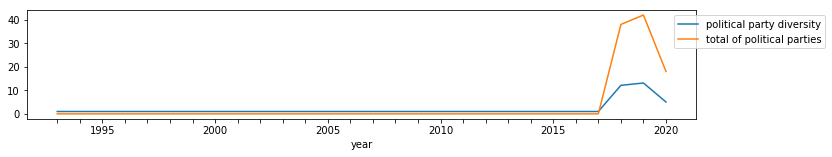

In [14]:
dates = np.arange(1993, 2021)
pps_div, pps_total = diversity_by_party(dates)

plt.figure(figsize=(12,2))
plt.plot(dates,pps_div,label='political party diversity')
#plt.plot(dates,comm_div,label='community diversity')
plt.plot(dates,pps_total,label='total of political parties')
#plt.plot(dates,comm_total,label='total of communities')
plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
labels = [str(int(x)) if float(x)%5 == 0 else '' for x in dates]
plt.xticks(np.arange(min(dates), max(dates)+1, 1.0),labels=labels)
plt.xlabel('year')
#plt.savefig(header+'divs.pdf',format='pdf',bbox_inches="tight")
plt.show()

# Info mutua

In [15]:
from sklearn.metrics import normalized_mutual_info_score

def info_mutua(grafo):
    mutual_info = []
    communities = list(grafo.get_node_attr('community').values())
    parties = [party for party in grafo.get_node_attr('party').values()]
    mutual_info = normalized_mutual_info_score(communities,parties,'geometric')
    return mutual_info

In [16]:
info_mutua(grafo)

-0.9375

# Modularidad

In [17]:
import igraph as ig

def modularity(grafo):
    mods_pps = []
    mods_comm = []
    years = grafo.years
    for year in years:
        #paso red a igraph
        ig_graph = ig.Graph.TupleList(grafo.get_edges(data = True), directed=False, weights = True)
        GC, _ = grafo.gigant_component()
        outside_GC = set(grafo.get_nodes()).difference((GC.nodes()))
        for node in outside_GC:
            ig_graph.add_vertex(node)
        
        parties = list(set(grafo.get_node_attr('party').values()))
        param_int = [parties.index(p) for p in grafo.get_node_attr('party').values()]
        print(len(param_int))
        vc_p = ig.VertexClustering(ig_graph, param_int, params={'weight':ig_graph.es['weight']})
        mods_pps.append(vc_p.modularity)
        
        comms = list(set(grafo.get_node_attr('community').values()))
        param_int_comm = [comms.index(p) for p in grafo.get_node_attr('community').values()]
        vc_comm = ig.VertexClustering(ig_graph,param_int_comm,params={'weight':ig_graph.es['weight']})
        mods_comm.append(vc_comm.modularity)
        
    return mods_pps, mods_comm


In [18]:
modularity(grafo)

259


([-0.0029839012843254705], [0.0])

# Shortest path

In [19]:
def shortest_path_mean(datas,nets):
    means = []
    for net in nets:
        vcount = net.vcount()
        dists = []
        for v in net.vs:
            path_lens = net.get_shortest_paths(v,to=net.vs,weights='weight')
            for p in path_lens:
                x = sum(net.es[idx]['distance'] for idx in p)
                if x > 0:
                    dists.append(x)
        m = mean(dists)
        means.append(m)
    dates = [int(d) for d in datas]
    plot(dates,means,'year','shortest paths mean','shortest_paths_mean')
    
## Necesita distance

# Distance

In [38]:
import numpy as np

def calculate_dist(grafo):
    weights = grafo.get_edge_attr('weight')
    total_votes = len(congreso.votings[2018])
    distance = {k: np.sqrt(2 * (1 - w / total_votes)) for k,w in weights.items()}
    grafo.set_edge_attributes(distance, 'distance')

In [41]:
calculate_dist(grafo)

# Shortest path mean 
De toda la red

In [157]:
from statistics import mean

def shortest_path_mean(grafo):
        GC, _ = grafo.gigant_component()
        len_nodes = len(GC.nodes())
        dists = []
        for node in GC.nodes():
            path_lens = nx.shortest_path(GC, node, weight = 'weight').values()
            for p in path_lens:
                if len(p) > 2:
                    x = sum([distance_edge(GC, p[i], p[i + 1]) for i in range(0, len(p) - 1 )])
                    dists.append(x)
        m = mean(dists)
        return m
                    
def distance_edge(grafo, node1, node2):
    return grafo.edges[node1, node2]['distance']                    

In [158]:
shortest_path_mean(grafo)

4.773544207559503